In [1]:
%autosave 60

Autosaving every 60 seconds


## Import Libraries and Dataset

In [21]:
import os ## directory operations
import zipfile ## opening zip file
import tarfile ## opening tar file
import shutil ## for moving file operations origin/destination
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
## Downloading datasets
# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

--2021-07-29 09:27:23--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.74.208, 142.250.185.176, 142.250.186.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.74.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip.1’

_3367a.zip.1         13%[=>                  ] 110,01M  6,81MB/s    eta 98s    ^C
--2021-07-29 09:27:45--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘storage.googleapis.com’


In [152]:
! rm -rf /tmp/data

## Combining the dataset

In [153]:
cats_and_dogs_zip = 'kagglecatsanddogs_3367a.zip'
caltech_birds_zip = 'CUB_200_2011.tgz'

base_dir = '/tmp/data'

In [154]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
    my_zip.extractall(base_dir)
    
with tarfile.open(caltech_birds_zip, 'r') as my_tar:
    my_tar.extractall(base_dir)

In [155]:
! ls /tmp/data/PetImages/

Cat  Dog


For the cats and dogs images no further preprocessing is needed as all exemplars of a single class are located in one directory: PetImages\Cat and PetImages\Dog respectively. Let's check how many images are available for each category:

In [156]:
base_dog_dir = os.path.join(base_dir, 'PetImages/Cat')
base_cat_dir = os.path.join(base_dir, 'PetImages/Dog')

base_dog_example = len(os.listdir(base_dog_dir))
base_cat_example = len(os.listdir(base_cat_dir))

print(f"There are {base_dog_example} images of dogs.")
print(f"There are {base_cat_example} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [157]:
raw_birds_dir = "/tmp/data/CUB_200_2011/images/"
base_bird_dir = os.path.join(base_dir, 'PetImages/Bird')
os.mkdir(base_bird_dir)

we need to move all raw_birds images to base_bird_dir

In [158]:
## moving the birds-images from raw_birs_dir to base_bird_dir
raw_birds_example = len(os.listdir(raw_birds_dir))

for sub_dir in os.listdir(raw_birds_dir):
    origin_images = [f.path for f in os.scandir(os.path.join(raw_birds_dir, sub_dir))]
    [shutil.move(images, base_bird_dir) for images in origin_images]

if len(os.listdir(base_bird_dir)) < raw_birds_example:
       print('Copying failed!!!')
else:
       print('Copying images from raw_birds_dir to base_bird_dir succedded!!')
       print(f'There are {len(os.listdir(base_bird_dir))} images of birds images.')

Copying images from raw_birds_dir to base_bird_dir succedded!!
There are 11788 images of birds images.


## Deleting non jpg files

In [159]:
import fnmatch
def delete_nonimage_files(base_dir):
    for image in os.listdir(base_dir):
        image_path = os.path.join(base_dir, image)
        image_size = os.path.getsize(image_path)
        if not fnmatch.fnmatch(image, '*jpg') or  image_size == 0 :
            print('file_name: ',image_path, 'size:',image_size, ' will be removed!')
            if os.path.exists(image_path) :
                os.remove(image_path)
            else :
                print ("The file", image," does not exist")    

In [160]:
dir_to_check = [base_dog_dir, base_bird_dir, base_cat_dir]
[delete_nonimage_files(f) for f in dir_to_check]

file_name:  /tmp/data/PetImages/Cat/Thumbs.db size: 4177194  will be removed!
file_name:  /tmp/data/PetImages/Cat/666.jpg size: 0  will be removed!
file_name:  /tmp/data/PetImages/Dog/11702.jpg size: 0  will be removed!
file_name:  /tmp/data/PetImages/Dog/Thumbs.db size: 13147136  will be removed!


[None, None, None]

In [161]:
## Lets check again howe many examples of each case we have
print(f"There are {len(os.listdir(base_bird_dir))} images of bird.")
print(f"There are {len(os.listdir(base_cat_dir))} images of cat.")
print(f"There are {len(os.listdir(base_dog_dir))} images of dog.")

There are 11788 images of bird.
There are 12499 images of cat.
There are 12499 images of dog.


## Display example images

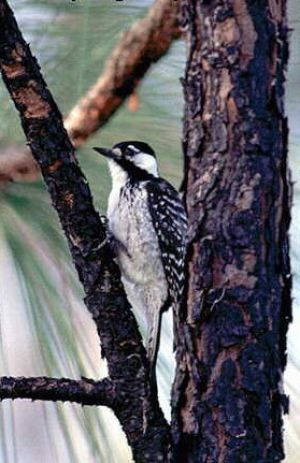

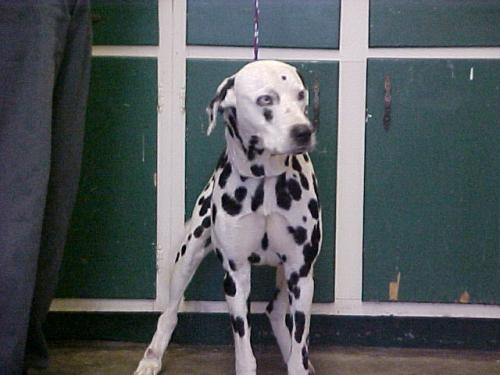

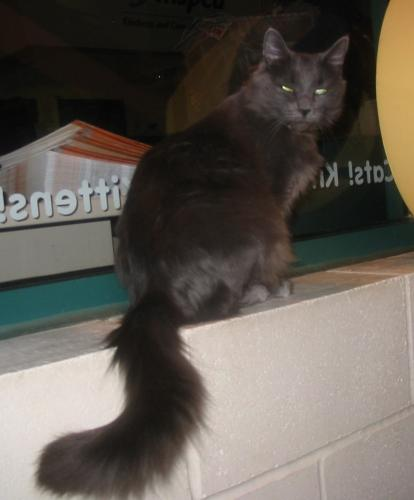

In [162]:
from IPython.display import Image, display
indx = 400
display(Image(filename=f"{os.path.join(base_bird_dir, os.listdir(base_bird_dir)[indx])}"))
display(Image(filename=f"{os.path.join(base_cat_dir, os.listdir(base_cat_dir)[indx])}"))
display(Image(filename=f"{os.path.join(base_dog_dir, os.listdir(base_dog_dir)[indx])}"))

## Train/Validation split
Before training the model you need to split the data into `training` and `evaluating` sets. For training, we have chosen the [`Keras`](https://keras.io) application programming interface (API) which includes functionality to read images from  various directories. The easier way to split the data is to create a different directory for each split of each class.


In [163]:
train_eval_dirs = ["train/cat", 'eval/cat', 'train/dog', 'eval/dog', 'train/bird', 'eval/bird']

for dirs in train_eval_dirs:
    if not os.path.exists(os.path.join(base_dir, dirs)):
        os.makedirs(os.path.join(base_dir, dirs))
    else:
        print('The directories exists already.')

In [164]:
## Lets define a function that will move the desired images from base_dir to train/eval directories
def move_to_destination(origin, destination, percentage):
    num_images = int(len(os.listdir(origin))*percentage)
    print(f"{len(os.listdir(origin))} images in {origin}, {num_images} moved to {destination}.")
    
    for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
        shutil.move(os.path.join(origin, image_name), destination)

In [165]:
move_to_destination(base_cat_dir, os.path.join(base_dir, "train/cat"), 0.7)
move_to_destination(base_dog_dir, os.path.join(base_dir, "train/dog"), 0.7)
move_to_destination(base_bird_dir, os.path.join(base_dir, "train/bird"), 0.7)

move_to_destination(base_cat_dir, os.path.join(base_dir, "eval/cat"), 1)
move_to_destination(base_dog_dir, os.path.join(base_dir, "eval/dog"), 1)
move_to_destination(base_bird_dir, os.path.join(base_dir, "eval/bird"), 1)

Total 12499 images in /tmp/data/PetImages/Dog, 8749 will be moved to /tmp/data/train/cat.
Total 12499 images in /tmp/data/PetImages/Cat, 8749 will be moved to /tmp/data/train/dog.
Total 11788 images in /tmp/data/PetImages/Bird, 8251 will be moved to /tmp/data/train/bird.
Total 3750 images in /tmp/data/PetImages/Dog, 3750 will be moved to /tmp/data/eval/cat.
Total 3750 images in /tmp/data/PetImages/Cat, 3750 will be moved to /tmp/data/eval/dog.
Total 3537 images in /tmp/data/PetImages/Bird, 3537 will be moved to /tmp/data/eval/bird.


## An unexpected issue
Let's face the first real life issue in this narrative! There was a power outage in your office and some hard drives were damaged and as a result of that, many of the images for `dogs` and `birds` have been erased. As a matter of fact, only 20% of the dog images and 10% of the bird images survived.


In [174]:
for dir in train_eval_dirs:
    if not os.path.exists(os.path.join(base_dir,'imbalanced/', dir)):
        os.makedirs(os.path.join(base_dir, 'imbalanced/', dir))
    else:
        print(f"{os.path.join(base_dir,'imbalanced/', dir)} already exists.")

/tmp/data/imbalanced/train/cat already exists.
/tmp/data/imbalanced/eval/cat already exists.
/tmp/data/imbalanced/train/dog already exists.
/tmp/data/imbalanced/eval/dog already exists.
/tmp/data/imbalanced/train/bird already exists.
/tmp/data/imbalanced/eval/bird already exists.


 We are ging to copy 20% of dog, 10% of bird from train/eval to imbalanced class

In [188]:
def copy_with_limit(origin, destination, percentage):
    num_images = int(len(os.listdir(origin))*percentage)
    print(f"{len(os.listdir(origin))} images in {origin}, {num_images} moved to {destination}.")

    for image_name,num_image in zip(sorted(os.listdir(origin)), range(num_images)):
        shutil.copy(os.path.join(origin, image_name), destination)

In [189]:
base_cat_dir

'/tmp/data/PetImages/Dog'

In [191]:
copy_with_limit(os.path.join(base_dir, "train/cat"), os.path.join(base_dir, 'imbalanced/train/cat'),1)
copy_with_limit(os.path.join(base_dir, "train/dog"), os.path.join(base_dir, 'imbalanced/train/dog'),0.2)
copy_with_limit(os.path.join(base_dir, "train/bird"), os.path.join(base_dir, 'imbalanced/train/bird'),0.1)

copy_with_limit(os.path.join(base_dir, "eval/cat"), os.path.join(base_dir, 'imbalanced/eval/cat'),1)
copy_with_limit(os.path.join(base_dir, "eval/dog"), os.path.join(base_dir, 'imbalanced/eval/dog'),0.2)
copy_with_limit(os.path.join(base_dir, "eval/bird"), os.path.join(base_dir, 'imbalanced/eval/bird'),0.1)

8749 images in /tmp/data/train/cat, 8749 moved to /tmp/data/imbalanced/train/cat.
8749 images in /tmp/data/train/dog, 1749 moved to /tmp/data/imbalanced/train/dog.
8251 images in /tmp/data/train/bird, 825 moved to /tmp/data/imbalanced/train/bird.
3750 images in /tmp/data/eval/cat, 3750 moved to /tmp/data/imbalanced/eval/cat.
3750 images in /tmp/data/eval/dog, 750 moved to /tmp/data/imbalanced/eval/dog.
3537 images in /tmp/data/eval/bird, 353 moved to /tmp/data/imbalanced/eval/bird.


In [199]:
from tensorflow.keras import layers, models, optimizers
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(3, activation='softmax')        
    ])
    
    # compile the model
    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics =[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    
    return model

In [200]:
## Create a imbalanced model
imbalanced_model = create_model()
imbalanced_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [201]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

## point to the imbalanced directory
train_generator      = train_datagen.flow_from_directory('/tmp/data/imbalanced/train/',
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='binary'
                                                   )

validation_generator = test_datagen.flow_from_directory('/tmp/data/imbalanced/eval/',
                                                 target_size=(150,150),
                                                 batch_size=32,
                                                 class_mode='binary')


Found 11323 images belonging to 3 classes.
Found 4853 images belonging to 3 classes.


Let's do a quick sanity check to inspect that both generators (training and validation) use the same labels for each class:

In [202]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'bird': 0, 'cat': 1, 'dog': 2}
labels for each class in the validation generator are: {'bird': 0, 'cat': 1, 'dog': 2}


## Training a model with imbalanced dataset


In [203]:
imbalanced_history = imbalanced_model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=50,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/50
100/100 [==============================] - 52s 518ms/step - loss: 0.7194 - sparse_categorical_accuracy: 0.7761 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.7777
Epoch 2/50
100/100 [==============================] - 58s 576ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.6354 - val_sparse_categorical_accuracy: 0.7703
Epoch 3/50
100/100 [==============================] - 56s 562ms/step - loss: 0.5512 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.4951 - val_sparse_categorical_accuracy: 0.8027
Epoch 4/50
100/100 [==============================] - 55s 549ms/step - loss: 0.4964 - sparse_categorical_accuracy: 0.8036 - val_loss: 0.5287 - val_sparse_categorical_accuracy: 0.7969
Epoch 5/50
100/100 [==============================] - 54s 544ms/step - loss: 0.4676 - sparse_categorical_accuracy: 0.8346 - val_loss: 0.4453 - val_sparse_categorical_accuracy: 0.8250
Epoch 6/50
100/100 [==============================] - 54s 545ms/step - loss: 0.4674 -

## Saving Model/History

In [241]:
## saving model
imbalanced_model.save('model-imbalanced')

INFO:tensorflow:Assets written to: model-imbalanced/assets


In [231]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open('trained_imbalancedhistory_Dict','wb') as file_pi:
    pickle.dump(imbalanced_history.history, file_pi)

## Plotting

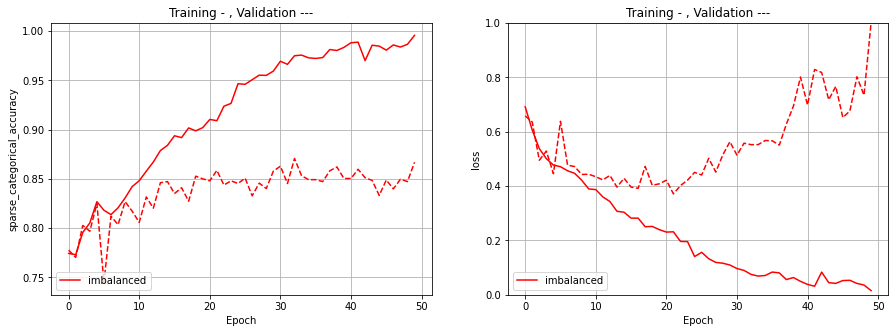

In [235]:
from ploting_script_bk2 import plot_n_model
plot_n_model(n=1, model_history=[imbalanced_history], 
             label_list=['imbalanced'], 
             is_sparse_categorical=True,
             ylim_low=0)

From these two plots is quite evident that the model is overfitting the training data. However, the evaluation accuracy is still pretty high. Maybe class imbalance is not such a big issue after all. Perhaps this is too good to be true. 

Let's dive a little deeper, and compute some additional metrics to explore if the class imbalance is hampering the model to perform well. In particular, let's compare: the accuracy score,  the accuracy score balanced, and the confusion matrix. 

In [245]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [246]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False) 

Found 4853 images belonging to 3 classes.


In [251]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

## Use the model to predict
prediction_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

## Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(prediction_imbalanced, axis=1)

## print accuracy score
print(f"Accuracy score : {accuracy_score(y_true, y_pred_imbalanced)}")

## print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

Accuracy score : 0.8627652998145477
Balanced Accuracy Score: 0.6959249606547057


Comparing the `accuracy` and `balanced accuracy` metrics, the class imbalance starts to become apparent. Now let's compute the `confusion matrix` of the predictions. Notice that the class imbalance is also present in the evaluation set so the confusion matrix will show an overwhelming majority for cats.

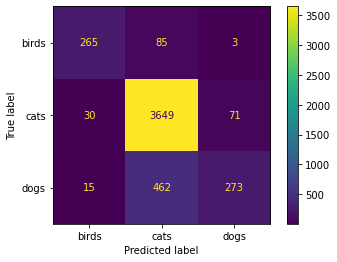

In [253]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format='d')

In [254]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 14.52%
Proportion of misclassified cats: 13.04%
Proportion of misclassified dogs: 21.33%


Class imbalance is a real problem that if not detected early on, gives the wrong impression that your model is performing better than it actually is. For this reason,  is important to rely on several metrics that do a better job at capturing these kinds of issues. **In this case the standard `accuracy` metric is misleading** and provides a false sense that the model is performing better than it actually is.

To prove this point further consider a model that only predicts cats:

In [277]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.3397662408263115
Balanced Accuracy Score: 0.3333333333333333


If you only look at the `accuracy` metric the model seems to be working fairly well, since the majority class is the same that the model always predicts.

There are several techniques to deal with class imbalance. A very popular one is `SMOTE`, which oversamples the minority classes by creating syntethic data.

The previous metrics were computed with class imbalance both on the training and evaluation sets. If you are wondering how the model performed with class imbalance only on the training set run the following cell to see the confusion matrix with balanced classes in the evaluation set:


Found 11037 images belonging to 3 classes.


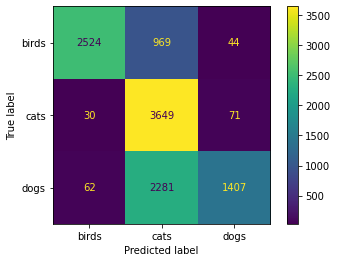

In [278]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [279]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 3.52%
Proportion of misclassified cats: 47.11%
Proportion of misclassified dogs: 7.56%


## Training CNN with the class Balanced data
Lets train on complete dataset.

Now that you have the complete dataset it is time to try again without suffering from class imbalance. In general, collecting more data is beneficial for models!

In [255]:
# Create a model to use with the balanced dataset
balanced_model = create_model()

In [256]:
# Still no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25749 images belonging to 3 classes.
Found 11037 images belonging to 3 classes.


In [257]:
balanced_history = balanced_model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=50,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/50
100/100 [==============================] - 55s 550ms/step - loss: 1.0842 - sparse_categorical_accuracy: 0.4116 - val_loss: 0.9362 - val_sparse_categorical_accuracy: 0.5664
Epoch 2/50
100/100 [==============================] - 58s 576ms/step - loss: 0.7974 - sparse_categorical_accuracy: 0.6177 - val_loss: 0.7419 - val_sparse_categorical_accuracy: 0.6566
Epoch 3/50
100/100 [==============================] - 58s 583ms/step - loss: 0.7212 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.6759 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/50
100/100 [==============================] - 59s 594ms/step - loss: 0.6830 - sparse_categorical_accuracy: 0.6796 - val_loss: 0.6810 - val_sparse_categorical_accuracy: 0.6668
Epoch 5/50
100/100 [==============================] - 59s 593ms/step - loss: 0.6740 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.6809
Epoch 6/50
100/100 [==============================] - 60s 595ms/step - loss: 0.6866 -

## Saving Model

In [271]:
## saving model
balanced_model.save('model-balanced')

INFO:tensorflow:Assets written to: model-balanced/assets


In [272]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open('trained_balancedhistory_Dict','wb') as file_pi:
    pickle.dump(balanced_history.history, file_pi)

## Prediction

In [258]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11037 images belonging to 3 classes.


In [259]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score of balanced dataset: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8670834465887469
Balanced Accuracy Score: 0.8687221185562152


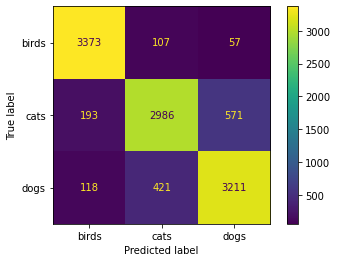

In [260]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

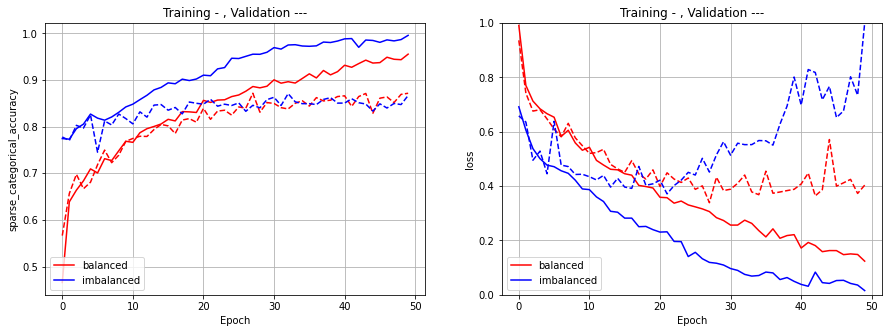

In [267]:
from ploting_script_bk2 import plot_n_model
plot_n_model(n=2, model_history=[balanced_history, imbalanced_history], 
             label_list=['balanced', 'imbalanced'], 
             is_sparse_categorical=True,
             ylim_low=0)

This looks much better than for the imbalanced case! However, overfitting is still present.
There are following ways to address overfitting:
1. we could loosen the model architecture, example: L1 Regularization, using 'dropout'
2. We could use data augmentation 

Here we give try the data augmentation techniques. 

# Training with Data Augmentation

Augmenting images is a technique in which you create new versions of the images you have at hand, by applying geometric transformations. These transformations can vary from: zooming in and out, rotating, or even flipping the images. By doing this, you get a training dataset that exposes the model to a wider variety of images. This helps in further exploring the feature space and hence reducing the chances of overfitting. 

It is also a very natural idea since doing slight (or sometimes not so slight) changes to an image will result in an equally valid image. 


In [263]:
# Create a model to use with the balanced and augmented dataset
augmented_model = create_model()

In [264]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25749 images belonging to 3 classes.
Found 11037 images belonging to 3 classes.


In [265]:
augmented_history = augmented_model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=80,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/80
100/100 [==============================] - 58s 572ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.3925 - val_loss: 0.8056 - val_sparse_categorical_accuracy: 0.5926
Epoch 2/80
100/100 [==============================] - 62s 621ms/step - loss: 0.8743 - sparse_categorical_accuracy: 0.5513 - val_loss: 0.8381 - val_sparse_categorical_accuracy: 0.6051
Epoch 3/80
100/100 [==============================] - 62s 615ms/step - loss: 0.8342 - sparse_categorical_accuracy: 0.5919 - val_loss: 0.7933 - val_sparse_categorical_accuracy: 0.6160
Epoch 4/80
100/100 [==============================] - 62s 616ms/step - loss: 0.7975 - sparse_categorical_accuracy: 0.6079 - val_loss: 0.7536 - val_sparse_categorical_accuracy: 0.6465
Epoch 5/80
100/100 [==============================] - 62s 620ms/step - loss: 0.7793 - sparse_categorical_accuracy: 0.6239 - val_loss: 0.6871 - val_sparse_categorical_accuracy: 0.6668
Epoch 6/80
100/100 [==============================] - 63s 631ms/step - loss: 0.7673 -

## Saving Model

In [275]:
## saving model
augmented_model.save('model-augmentated')

INFO:tensorflow:Assets written to: model-augmentated/assets


In [274]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open('trained_augmentatedhistory_Dict','wb') as file_pi:
    pickle.dump(augmented_history.history, file_pi)

In [276]:
! ls

C1W2_Ungraded_Lab_Birds_Cats_Dogs.ipynb  ploting_script_bk2.py
CUB_200_2011.tgz			 __pycache__
kagglecatsanddogs_3367a.zip		 trained_augmentatedhistory_Dict
model-augmentated			 trained_balancedhistory_Dict
model-balanced				 trained_imbalancedhistory_Dict
model-imbalanced			 Untitled.ipynb


In [280]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_augmentated = augmented_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_augmentated = np.argmax(predictions_augmentated, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_augmentated)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score of balanced augmentated dataset: {balanced_accuracy_score(y_true, y_pred_augmentated)}")

Accuracy Score: 0.8539458186101295
Balanced Accuracy Score of balanced augmentated dataset: 0.8557422297615682


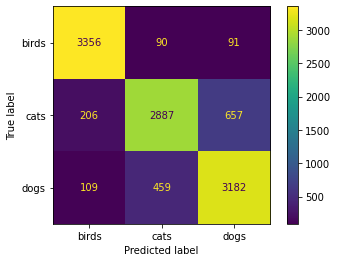

In [270]:
balanced_cm = confusion_matrix(y_true, y_pred_augmentated)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

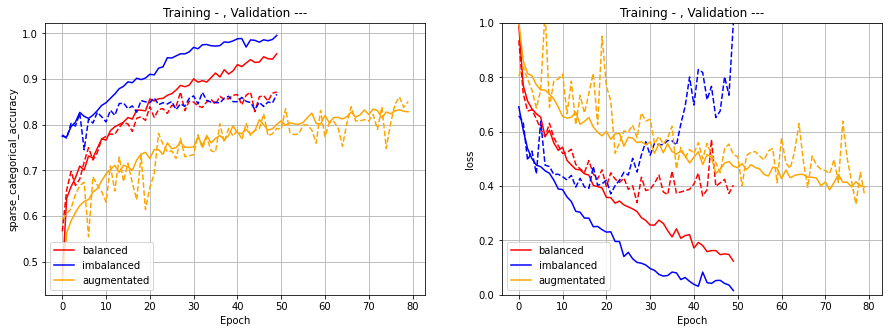

In [268]:
plot_n_model(n=3, model_history=[balanced_history, imbalanced_history, augmented_history], 
             label_list=['balanced', 'imbalanced','augmentated'], 
             is_sparse_categorical=True,
             ylim_low=0)

## Load pretrained model and history

In [282]:
# Load pretrained model and history
imbalanced_model = tf.keras.models.load_model('model-balanced')

## history
try: 
    import dill as pickle                                                    
except ImportError:                                                         
    import pickle                                                            
calling_saved_history = pickle.load(open('trained_balancedhistory_Dict', "rb"))         

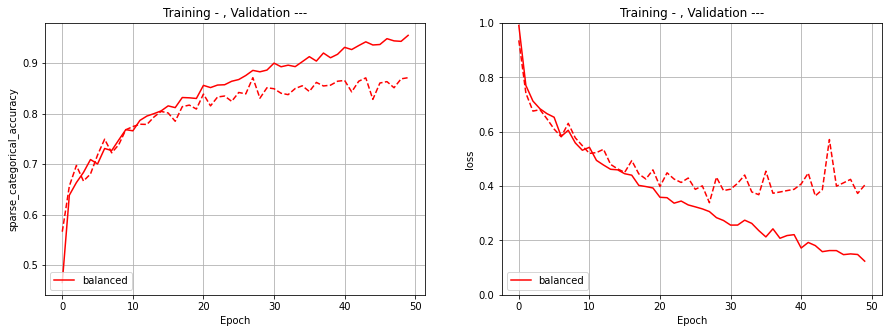

In [286]:
plot_n_model(n=1, model_history=[calling_saved_history], 
             is_saved_history=True, 
             label_list=['balanced'], 
             is_sparse_categorical=True, ylim_low=0)